In [1]:
!pip install torch torchvision torchaudio scikit-learn

You should consider upgrading via the '/Users/sandbye/Documents/GitHub/summer-school-ai/summer_env/bin/python3 -m pip install --upgrade pip' command.


In [2]:
"""
Created on Thu Aug  1 19:42:57 2024

@author: vigo
"""


import os
import sys
import argparse
import time
from tqdm import trange
import numpy as np
import PIL
import numpy as np
import random
from PIL import Image, ImageDraw
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet50
import matplotlib.pyplot as plt

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device.")
else:
    device = torch.device("cpu")
    print("MPS device not found. Using CPU instead.")
    
#device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

print(device)

# Hyper-parameters 
batch_size = 32
n_epochs = 20
learning_rate = 1e-4



# Specify the root folders for neoplastic and nonneoplastic images
neoplastic_folder = './PCData/Neoplasia'
nonneoplastic_folder = './PCData/Non-neoplasia'  


nonneoplastic_data = [(os.path.join(nonneoplastic_folder, file), 0) for file in os.listdir(nonneoplastic_folder) if not file.startswith('.')]
neoplastic_data = [(os.path.join(neoplastic_folder, file), 1) for file in os.listdir(neoplastic_folder) if not file.startswith('.')]
data = neoplastic_data + nonneoplastic_data

# Create the train dataset using train_data.txt
train_data = []
train_ids = set()  # Define train_ids before adding elements to it
# Assuming train_data.txt contains data in the format: id \t ccenum \t class_type
with open('train_data.txt', 'r') as file:
    for line in file:
        # Assuming train_data.txt contains data in the format: id \t ccenum \t class_type
        sdkid = line.strip().split(',')[0]
        train_ids.add(sdkid)


# Iterate through your neoplastic and nonneoplastic data
for filepath, label in data:
    filename = os.path.basename(filepath)
    sdkid_train = filename.split('_')[0]  # Assuming sdkid is the prefix before '_'
    #print(sdkid_data)
    if sdkid_train in train_ids:
        train_data.append((filepath, label))



# Create the valid dataset using valid_data.txt
valid_data = []
valid_ids = set()  # Define train_ids before adding elements to it
# Assuming train_data.txt contains data in the format: id \t ccenum \t class_type
with open('valid_data.txt', 'r') as file:
    for line in file:
        # Assuming train_data.txt contains data in the format: id \t ccenum \t class_type
        sdkid = line.strip().split(',')[0]
        valid_ids.add(sdkid)

# Iterate through your neoplastic and nonneoplastic data
for filepath, label in data:
    filename = os.path.basename(filepath)
    sdkid_val = filename.split('_')[0]  # Assuming sdkid is the prefix before '_'
    #print(sdkid_data)
    if sdkid_val in valid_ids:
        valid_data.append((filepath, label))
              
# Create the test dataset using train_data.txt
test_data = []
test_ids = set()  # Define train_ids before adding elements to it
# Assuming train_data.txt contains data in the format: id \t ccenum \t class_type
with open('test_data.txt', 'r') as file:
    for line in file:
        # Assuming train_data.txt contains data in the format: id \t ccenum \t class_type
        sdkid = line.strip().split(',')[0]
        test_ids.add(sdkid)

# Iterate through your neoplastic and nonneoplastic data
for filepath, label in data:
    filename = os.path.basename(filepath)
    sdkid_test = filename.split('_')[0]  # Assuming sdkid is the prefix before '_'
    #print(sdkid_data)
    if sdkid_test in test_ids:
        test_data.append((filepath, label))


class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label, os.path.basename(img_path)
    
    

# Define a variety of augmentations without resizing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize images 
])

# Create the custom dataset instances for training, validation, and testing
train_dataset = CustomDataset(data=train_data, transform=transform)
valid_dataset = CustomDataset(data=valid_data, transform=transform)
test_dataset = CustomDataset(data=test_data, transform=transform)



# Create DataLoader for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Using MPS device.
mps


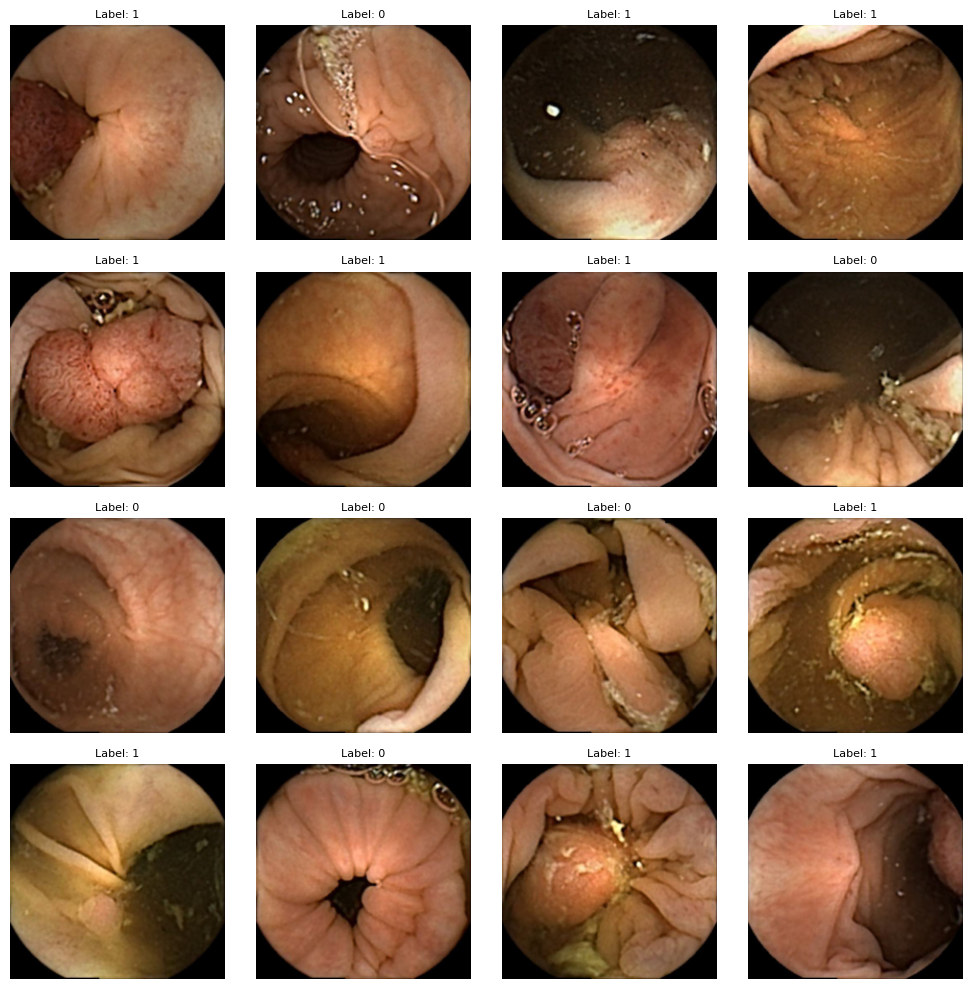

In [3]:
def unnormalize(img):
    img = img * 0.5 + 0.5  # reverse normalization
    return img

# select 16 random indices for plotting
indices = random.sample(range(len(train_dataset)), 16)

plt.figure(figsize=(10, 10))

for i, idx in enumerate(indices):
    image, label, image_name = train_dataset[idx]

    if isinstance(image, torch.Tensor):
        image = image.numpy()

    if image.shape[0] == 3:  # RGB
        image = np.transpose(image, (1, 2, 0))
        image = unnormalize(image)
    elif image.shape[0] == 1:  # Grayscale
        image = image.squeeze(0)
        image = unnormalize(image)

    plt.subplot(4, 4, i + 1)
    plt.imshow(image, cmap='gray' if image.ndim == 2 else None)
    plt.title(f"Label: {label}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Initialize the model, criterion, optimizer
pc_model = resnet18(pretrained=True).to(device)  # Single output for binary classification
pc_model.fc = nn.Linear(pc_model.fc.in_features, 1)
pc_model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(pc_model.parameters(), lr=learning_rate, betas=(0.9, 0.999))


/Users/sandbye/Documents/GitHub/summer-school-ai/summer_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sandbye/Documents/GitHub/summer-school-ai/summer_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/sandbye/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:02<00:00, 21.6MB/s]


In [5]:
def train(model, device, dataloader, criterion, optimizer):
    model.train()
    train_correct = 0
    n_total_steps = len(dataloader.sampler)
    for images, targets, image_names in dataloader:
        images, targets = images.to(device), targets.to(device).float().view(-1, 1) 
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, targets)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        predictions = (torch.sigmoid(outputs) > 0.65).float()
        train_correct += (predictions == targets).sum().item()
            
    # Calculate training accuracy
    train_acc = train_correct / n_total_steps * 100
    return train_acc

def val(model, device, dataloader, criterion):
    n_total_samples = 0
    val_loss = 0
    val_correct = 0
    model.eval()
    with torch.no_grad():
        for images, targets, image_names in dataloader:
            images, targets = images.to(device), targets.to(device).float().view(-1, 1) 
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            predictions = (torch.sigmoid(outputs) > 0.65).float()
            val_correct += (predictions == targets).sum().item()
            n_total_samples += targets.size(0)
        
    val_acc = val_correct / n_total_samples * 100
    avg_val_loss = val_loss / len(dataloader)
    return avg_val_loss, val_acc



for e in range(n_epochs):
    train_acc = train(pc_model, device, train_loader, criterion, optimizer)
    val_loss, val_acc = val(pc_model, device, val_loader, criterion)
    print(f'Epoch [{e+1}/{n_epochs}], Train Accuracy: {train_acc:.2f}%, Val Accuracy: {val_acc:.2f}%, Val Loss: {val_loss:.4f}')
       

test_loss, test_acc = val(pc_model, device, test_loader, criterion)
print(f'Test Accuracy: {test_acc:.2f}%')

Epoch [1/20], Train Accuracy: 74.76%, Val Accuracy: 93.24%, Val Loss: 0.1858
Epoch [2/20], Train Accuracy: 97.01%, Val Accuracy: 94.13%, Val Loss: 0.1412
Epoch [3/20], Train Accuracy: 99.10%, Val Accuracy: 93.59%, Val Loss: 0.1296
Epoch [4/20], Train Accuracy: 99.64%, Val Accuracy: 95.20%, Val Loss: 0.1426
Epoch [5/20], Train Accuracy: 99.64%, Val Accuracy: 95.20%, Val Loss: 0.1404
Epoch [6/20], Train Accuracy: 99.40%, Val Accuracy: 95.02%, Val Loss: 0.1592
Epoch [7/20], Train Accuracy: 97.67%, Val Accuracy: 93.24%, Val Loss: 0.1921
Epoch [8/20], Train Accuracy: 98.80%, Val Accuracy: 93.24%, Val Loss: 0.1534
Epoch [9/20], Train Accuracy: 99.46%, Val Accuracy: 96.09%, Val Loss: 0.1404
Epoch [10/20], Train Accuracy: 99.52%, Val Accuracy: 95.20%, Val Loss: 0.1470
Epoch [11/20], Train Accuracy: 98.33%, Val Accuracy: 92.88%, Val Loss: 0.2488
Epoch [12/20], Train Accuracy: 99.40%, Val Accuracy: 95.20%, Val Loss: 0.1476
Epoch [13/20], Train Accuracy: 99.64%, Val Accuracy: 94.31%, Val Loss: 0.